<br/>

# <center>DSA8023: Analytics in Action</center>
<!-- ### <center>(Course Code: MGT7177) -->

<br/>

<br/>

# <center>Analython 1 Project: <br/>Suspected EV Customers Challenge from Energia 

<br/>

<br/>

### <br/><p style="text-align: left; width: 50%; float: left"> Varun Suresh Kumar <br/><br/> Student ID: 40364111 <br/><br/> vsureshkumar01@qub.ac.uk</p><p style="text-align: right; width: 50%; float: right">  <br/><br/> Submitted on: 18/14/2023 <br/><br/> Page count: 12 </p>

<hr/>


## Introduction and Background

Based on market research, Ireland (ROI) has 70,000 Electric Vehicle(EV) Customers who own an EV; out of which Energia has 10% of the market share. Around 2.4K EV Customers are identified from Energia database as they are part of the EV Tariff. 
This analysis is target towards identifying the remaining share of EV Customers using the bimonthly electrical billing data of customers from January 2021 to January 2023.

This dataset consists of information on their account IDs, customers start date, their EV contract start and end dates, their title, EV contract type(New or Old), age band, channel through which they signedup and Geo-financial classification.

The following report will consist of Exploratory Data Analysis of the dataset, steps involved in cleaning / classification of the data, the analysis of the data against Logistic Regression modal(3 variants), Decision Tree algorithm modal and finally the recommendations and conclusions inferred from the analysis. This analysis is performed in Python language using sklearn library. 

## Research Objectives:
This analysis aims at developing a statistical modal to predict and classify the customers whether they use a EV vehicles or not.


## Methodology
## Conclusion
This analysis aims at developing a mechanism to predict the credit card default beforehand and to identify the potential customer base that can be offered
various credit instruments so as to invite minimum default


# Table of Content

* [Objectives](#obj)
* [Importing packages and loading data](#imp)
* [Feature Engineering](#fe)
* [Exploratory Data Analysis (EDA)](#eda)
    * [Mapping the target: categorizing](#map)
    * [Descriptive Statistics](#stat)
    * [Standardizing and plotting features](#std)
    * [Correlation](#corr)
* [Machine Learning: Classification models](#ml)
    * [Feature Selection](#fs)
    * [Spliting the data: train and test](#sp)
    * [Logistic Regression (original data)](#lr1)
    * [Logistic Regression (standardized features)](#lr2)
    * [Logistic Regression (most important features)](#lr3)
    * [ExtraTree-decision](#tree)
    * [Random-Forest Classifier](#rf)
* [Comparison of model performance](#sum)
    * [Receiver operating characteristic (ROC) Curve](#roc)
    * [Mean Accuracy (coss-validation)](#ac)
    * [Precision, Recall, F1-score](#m)

## Feature Engineering
categorical to numerical
monthly average applied

## Data cleaning
reason for deleting columns - 
reason for deleting null rows

## EDA
bar graph showing EV and non EV split


<a id='eda'></a>
## Exploratory Data Analysis (EDA)


<a id='31'></a>
### Check the data  


In [ ]:
print('Shape of the dataset is {}'.format(raw_d.shape))

In [269]:
print('Features of the dataset:')
raw_d.columns.to_list()

Features of the dataset:


['accountID',
 'StartDate',
 'ContractStartDateEV',
 'contractStartDate',
 'contractEndDate',
 'saStatus',
 'agedBand',
 'signedUpGroup',
 'title',
 'mosaicType',
 'EV',
 'EV_New_or_Old',
 'bill_1_2021',
 'bill_2_2021',
 'bill_3_2021',
 'bill_4_2021',
 'bill_5_2021',
 'bill_6_2021',
 'bill_1_2022',
 'bill_2_2022',
 'bill_3_2022',
 'bill_4_2022',
 'bill_5_2022',
 'bill_6_2022',
 'bill_1_2023']


<a id='eda_map'></a>
### Categorizing target class: 

From this sample of **1,86,558 Energia customers**, there are **2,516 known EV** customers. The proportion of EV customers in the dataset is **1.35% (very low)** so this is **highly imbalanced dataset**.

    

In [259]:
print('Shape of the dataset is {}'.format(raw_d.shape))

Shape of the dataset is (186558, 25)


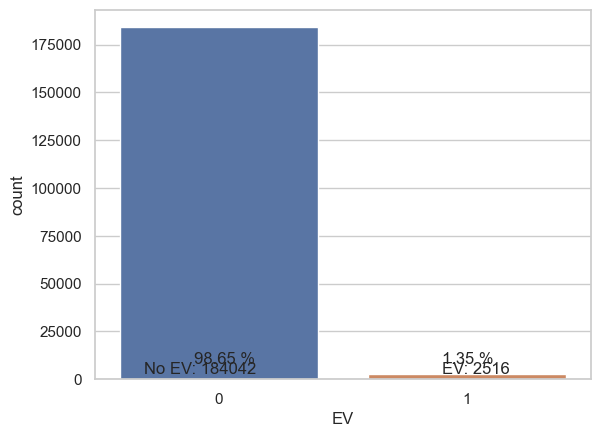

In [225]:
visualizeFeatureCount(raw_d.replace({'EV': {'N':0, 'Y': 1}}))

In [258]:

print("Descriptive Statistics")
print()
# print(raw_d.describe().T)
pd.set_option('display.width', 100)

def checkCateoricalInfo(data, cols):
    for col in cols:
        unique = data[col].unique()
        print('{} ({})'.format(col, len(unique)));
        print(unique)
        print()
        
categorical_columns = ['title', 'mosaicType', 'agedBand', 'saStatus', 'signedUpGroup']

checkCateoricalInfo(raw_d, categorical_columns)


Descriptive Statistics

title (10)
['Mr' 'Ms' 'Mrs' ' ' 'Miss' 'Dr' 'Mr & Mrs' nan 'Rev' 'Cllr']

mosaicType (44)
[nan 'F17' 'G18' 'K31' 'M37' 'G19' 'N42' 'L33' 'B04' 'C09' 'M38' 'E14'
 'B06' 'A03' 'J29' 'A02' 'C07' 'F15' 'N43' 'H22' 'K30' 'C08' 'J28' 'L35'
 'E13' 'B05' 'J26' 'N40' 'A01' 'H23' 'K32' 'D10' 'N41' 'G20' 'I24' 'M39'
 'F16' 'D11' 'J27' 'L34' 'H21' 'L36' 'I25' 'D12']

agedBand (9)
['41 to 50' 'Unclassified' '51 to 60' '61 to 70' '25 to 40' '70+'
 '19 to 24' nan '18 & Under']

saStatus (1)
['Active']

signedUpGroup (6)
['PCW' 'Telesales' 'Other' 'Web' 'Field Sales' 'OBS']



AxesSubplot(0.125,0.11;0.775x0.77)


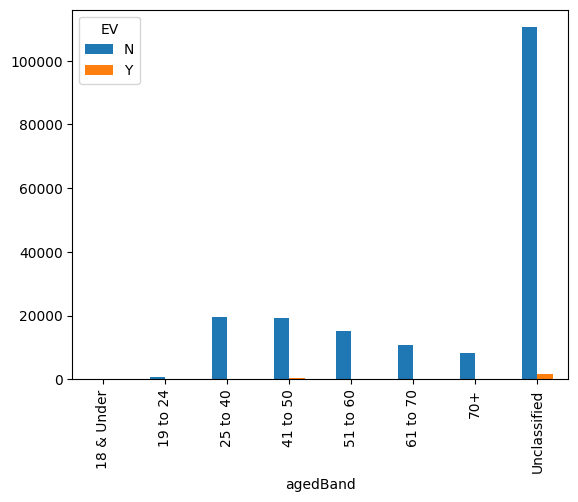

In [183]:
Crosstabresult = pd.crosstab(raw_d["agedBand"], raw_d["EV"]).plot( kind = "bar")
print(Crosstabresult)


In [271]:
(raw_d.isin([0,]).sum()/len(raw_d)*100).sort_values(ascending = False)


ContractStartDateEV    98.651358
mosaicType             22.792912
contractEndDate         0.518337
contractStartDate       0.309287
agedBand                0.003216
title                   0.001072
accountID               0.000000
bill_5_2021             0.000000
bill_6_2022             0.000000
bill_5_2022             0.000000
bill_4_2022             0.000000
bill_3_2022             0.000000
bill_2_2022             0.000000
bill_1_2022             0.000000
bill_6_2021             0.000000
bill_1_2021             0.000000
bill_4_2021             0.000000
bill_3_2021             0.000000
bill_2_2021             0.000000
StartDate               0.000000
EV_New_or_Old           0.000000
EV                      0.000000
signedUpGroup           0.000000
saStatus                0.000000
bill_1_2023             0.000000
dtype: float64

AxesSubplot(0.125,0.11;0.775x0.77)


EV,N,Y
mosaicType,,
J28,5756,146
J27,4153,137
M37,6607,107
A02,3554,105
J29,5575,97
B04,4635,88
M38,6377,86
G18,6208,80
A03,5296,72


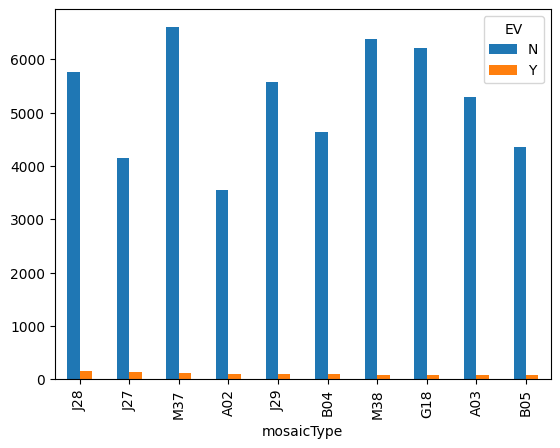

In [193]:
Crosstabresult = pd.crosstab(raw_d["mosaicType"], raw_d["EV"]).sort_values(by='Y', ascending=False).head(10).plot( kind = "bar")
print(Crosstabresult)

pd.crosstab(raw_d["mosaicType"], raw_d["EV"]).sort_values(by='Y', ascending=False).head(10)


In [25]:
import warnings
warnings.filterwarnings(action='once')

from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

sklearn.exceptions.ConvergenceWarning('ignore')

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # used for plot interactive graph.
import seaborn.objects as so

from sklearn.model_selection import train_test_split # to split the data into two parts
from collections import Counter
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.

from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from scipy.stats import boxcox
from sklearn import metrics # for the check the error and accuracy of the model

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

sns.set_theme(style="whitegrid")
# from xgboost import XGBClassifier

from tabulate import tabulate

In [29]:
#reading and concatinating customer data

raw_1 = pd.read_excel('D:/UK/assignment/DSA8023/WB1_Energia_Challenge_March_2023_Data.xlsx', sheet_name=1)
raw_2 = pd.read_excel('D:/UK/assignment/DSA8023/WB2_Energia_Challenge_March_2023_Data.xlsx', sheet_name=1)
raw_d = pd.concat([raw_1, raw_2])

In [7]:
# Defining constants

billing_months = ['bill_1_2021', 'bill_2_2021',
       'bill_3_2021', 'bill_4_2021', 'bill_5_2021', 'bill_6_2021',
       'bill_1_2022', 'bill_2_2022', 'bill_3_2022', 'bill_4_2022',
       'bill_5_2022', 'bill_6_2022', 'bill_1_2023']

categorical_columns = ['title', 'mosaicType', 'agedBand', 'saStatus', 'signedUpGroup']

# based on the fact that ifn one reading is missed for a particular month, the reading will be accumulated to next month.
# the reading is averaged between missing and accumulated months.
# only one missed month is accepted thus eleminating rows with consecutive zeros
# end result will have no zero readings
def average_missing_months(x):
    for index, month in enumerate(billing_months[:-1]):
        next_month = billing_months[index+1]
        if x[month] == 0:
            if(x[next_month] != 0):
                x[month] = x[next_month] / 2
                x[next_month] = x[next_month] / 2
            else:
                break
    return x

def checkCateoricalInfo(data, cols):
    for col in cols:
        unique = data[col].unique()
        print('{}({}) - {}'.format(col, len(unique), unique));
        print()


In [8]:
df = raw_d.copy()

checkCateoricalInfo(df, categorical_columns)

le = LabelEncoder()
 
# keeping nan values in title, agedband as they have relatively less effect on EV classification
df['title'] = le.fit_transform(df['title'])
df['mosaicType'] = le.fit_transform(df['mosaicType'])
df['agedBand'] = le.fit_transform(df['agedBand'])
df['signedUpGroup'] = le.fit_transform(df['signedUpGroup'])
df['saStatus'] = le.fit_transform(df['saStatus'])


# manually assigning numeric values to EV related categories
rename_props = { 'EV': {'N': 0, 'Y': 1},
                  'EV_New_or_Old': {'Non-EV Customers': 0, 'Switched to EV': 1, 'New EV Customer': 1}} 

df = df.replace(rename_props)


title(10) - ['Mr' 'Ms' 'Mrs' ' ' 'Miss' 'Dr' 'Mr & Mrs' nan 'Rev' 'Cllr']

mosaicType(44) - [nan 'F17' 'G18' 'K31' 'M37' 'G19' 'N42' 'L33' 'B04' 'C09' 'M38' 'E14'
 'B06' 'A03' 'J29' 'A02' 'C07' 'F15' 'N43' 'H22' 'K30' 'C08' 'J28' 'L35'
 'E13' 'B05' 'J26' 'N40' 'A01' 'H23' 'K32' 'D10' 'N41' 'G20' 'I24' 'M39'
 'F16' 'D11' 'J27' 'L34' 'H21' 'L36' 'I25' 'D12']

agedBand(9) - ['41 to 50' 'Unclassified' '51 to 60' '61 to 70' '25 to 40' '70+'
 '19 to 24' nan '18 & Under']

saStatus(1) - ['Active']

signedUpGroup(6) - ['PCW' 'Telesales' 'Other' 'Web' 'Field Sales' 'OBS']



In [274]:
def visualizeFeatureCount(dataset, feature = 'EV'):
    totalData = len(dataset)
    hasFeature = dataset[feature].sum()
    
#     print(totalData, has)
    hasNoFeature = totalData - hasFeature

    hasFeature_per = round(hasFeature/totalData * 100, 2)
    hasNoFeature_per = round(hasNoFeature/totalData * 100, 2)

    plt.figure(figsize=(3,3))
    sns.countplot(data = dataset, x=feature)
    plt.annotate('No {}: {}'.format(feature, hasNoFeature), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
    plt.annotate('{}: {}'.format(feature, hasFeature), xy=(0.7, 15000), xytext=(0.9, 3000), size=12)
    plt.annotate(str(hasNoFeature_per)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
    plt.annotate(str(hasFeature_per)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
    plt.show()

def plot_hist_plots(t_data, t_features, fig_size= 8):
    f = plt.figure(figsize=(fig_size,fig_size))
    for i, feature in enumerate(t_features):
        t = f.add_subplot(round(len(t_features)/3) + 1,3, i+1)
        sns.histplot(t_data[feature])
        t.title.set_text(feature)
    plt.show();

def plot_corr_plot(ds):
    corr = ds.corr(numeric_only=True) # .corr is used to find corelation
    f,ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
                xticklabels= True, yticklabels= True
                ,cmap="coolwarm", linewidths=.5, ax=ax)
    plt.title('CORRELATION MATRIX - HEATMAP', size=18);
    
def predict_and_visualize(model, class_col, dataset=None, class_col_predicted= 'EV_predicted'):
    
    if dataset is None:
        x = df.copy()
        
    else:
        x = dataset.copy()
        
    x= x.drop(columns=[class_col])
    x[class_col_predicted] = model.predict(x)
    visualizeFeatureCount(x, feature='EV_predicted')
    


In [10]:
df = df.apply(average_missing_months, axis=1)

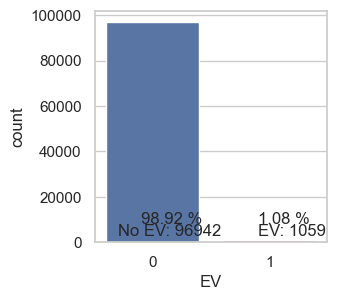

In [275]:

# initial data cleaning

# deleting date related 
cols_to_delete = ['StartDate','ContractStartDateEV','contractStartDate','contractEndDate','saStatus', 'accountID']
if df.columns.isin(cols_to_delete).any():
    df = df.drop(columns=cols_to_delete)

def get_cleaned_data(df, is_zero_bill_value_allowed):
    if is_zero_bill_value_allowed:
        df['zero_count'] = df[billing_months].isin([0]).sum(axis=1)
        cleaned_data = df.copy()
    else:
        cleaned_data = df[~df[billing_months].isin([0]).any(axis=1)]
    
    return cleaned_data
cleaned_data = get_cleaned_data(df, is_zero_bill_value_allowed = False)


visualizeFeatureCount(cleaned_data)    

In [12]:
# plot heat map of correlation features
# plot_corr_plot(cleaned_data)

In [13]:
# check distribution of billing features before transforming
# plot_hist_plots(cleaned_data, cleaned_data.columns, fig_size=12)


In [14]:
# ignore - Applying log transformation to fix right skewness in billing period distribution
# sqrt_t_data = cleaned_data.copy()

# for month in billing_months:
#     sqrt_t_data[month] = np.sqrt(sqrt_t_data[month])

# plot_hist_plots(sqrt_t_data, billing_months)

In [113]:
# perform logistic regression

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


def perform_sampling(x_train, y_train, y_test, sampling=None):
    if sampling:
        print('Training set shape: {}'.format(Counter(y_train)))

        if sampling == 'under':
            from imblearn.under_sampling import NearMiss 
            sampler = NearMiss(version=1, n_neighbors=3)
        elif sampling == 'over':
            from imblearn.over_sampling import SMOTE 
            sampler = SMOTE(random_state=42)

        x_train, y_train = sampler.fit_resample(x_train, y_train)
        print('Training set after sampling: {}'.format(Counter(y_train)))
        
    return x_train, y_train

@ignore_warnings(category=ConvergenceWarning)
def perform_logistic_reg(data, class_col, sampling=None, solver='lbfgs', weight = None, return_metrics = False):
    x = data.drop(class_col, axis=1)  
    y = data[class_col]

    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, stratify=y, random_state=42)
    
    if sampling:
        X_train, y_train = perform_sampling(X_train, y_train,y_test,  sampling)

    LR = LogisticRegression(C=0.00005, random_state=0, solver=solver ,class_weight = weight)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    metrics = get_metrics(y_pred, X_test, y_test, LR, x, y, sampling, modal_name='Linear Regression')
    
    return LR, metrics 
    
def get_metrics(y_pred, X_test, y_test, LR, x, y, sampling = None, modal_name = ''):
    ## 5-fold cross-validation 
    cv_scores =cross_val_score(LR, x, y, cv=10)

    modal_report = classification_report(y_test, y_pred, output_dict = True)
    # Print the 5-fold cross-validation scores
    print()
    print(classification_report(y_test, y_pred))
    print()
    print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
          ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

    plt.figure(figsize=(4,3))
    ConfMatrix = confusion_matrix(y_test,LR.predict(X_test))
    sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
                xticklabels = ['No EV', 'EV'], 
                yticklabels = ['No EV', 'EV'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix - {} - {}".format(modal_name, sampling));
    
    total1=sum(sum(ConfMatrix))
    #####from confusion matrix calculate accuracy
    modal_metrics = metrics.accuracy_score(y_pred,y_test)
    print('Accuracy:', modal_metrics)
    sensitivity = ConfMatrix[0,0]/(ConfMatrix[0,0]+ConfMatrix[0,1])
    print('Sensitivity : ', sensitivity )
    specificity = ConfMatrix[1,1]/(ConfMatrix[1,0]+ConfMatrix[1,1])
    print('Specificity : ', specificity)
    
    return modal_report

In [120]:
LR_over_metrics

{'0': {'precision': 0.9960302457466919,
  'recall': 0.8152560730311001,
  'f1-score': 0.8966221390283332,
  'support': 19389},
 '1': {'precision': 0.039935674082015545,
  'recall': 0.7028301886792453,
  'f1-score': 0.07557697184884606,
  'support': 212},
 'accuracy': 0.8140400999948982,
 'macro avg': {'precision': 0.5179829599143537,
  'recall': 0.7590431308551727,
  'f1-score': 0.4860995554385896,
  'support': 19601},
 'weighted avg': {'precision': 0.9856893422625375,
  'recall': 0.8140400999948982,
  'f1-score': 0.8877418994771853,
  'support': 19601}}

Training set shape: Counter({0: 77553, 1: 847})
Training set after sampling: Counter({0: 77553, 1: 77553})

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     19389
           1       0.04      0.70      0.08       212

    accuracy                           0.81     19601
   macro avg       0.52      0.76      0.49     19601
weighted avg       0.99      0.81      0.89     19601


Average 5-Fold CV Score: 0.9888 , Standard deviation: 0.0002
Accuracy: 0.8140400999948982
Sensitivity :  0.8152560730311001
Specificity :  0.7028301886792453


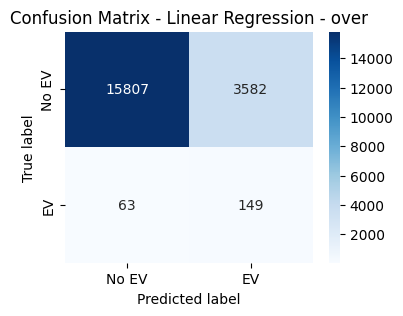

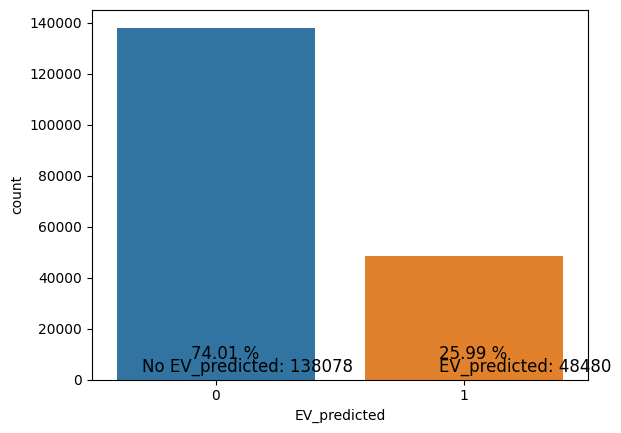

In [115]:
LR_over, LR_over_metrics = perform_logistic_reg(cleaned_data, class_col='EV', sampling='over')
predict_and_visualize(LR2, 'EV', dataset=df)

Training set shape: Counter({0: 77553, 1: 847})
Training set after sampling: Counter({0: 847, 1: 847})

              precision    recall  f1-score   support

           0       1.00      0.57      0.73     19389
           1       0.02      0.85      0.04       212

    accuracy                           0.58     19601
   macro avg       0.51      0.71      0.39     19601
weighted avg       0.99      0.58      0.72     19601


Average 5-Fold CV Score: 0.9888 , Standard deviation: 0.0002
Accuracy: 0.5770113769705627
Sensitivity :  0.5740368250038682
Specificity :  0.8490566037735849


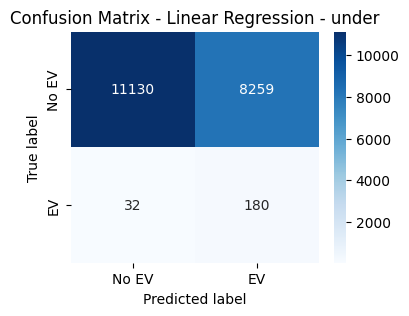

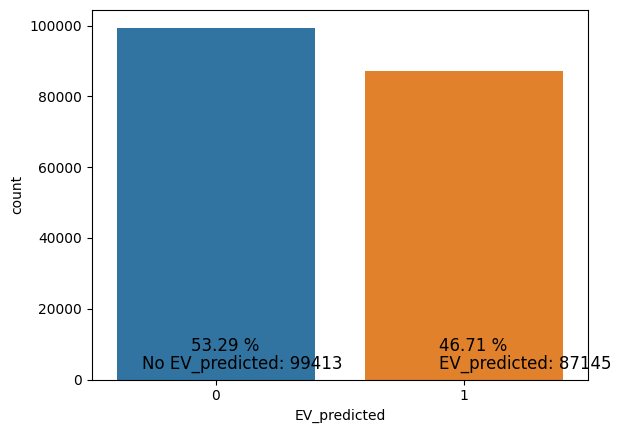

In [110]:
LR_under, LR_under_metrics = perform_logistic_reg(cleaned_data, class_col='EV', sampling='under')
predict_and_visualize(LR_under, 'EV', dataset=df)


              precision    recall  f1-score   support

           0       1.00      0.77      0.87     19389
           1       0.03      0.75      0.07       212

    accuracy                           0.77     19601
   macro avg       0.52      0.76      0.47     19601
weighted avg       0.99      0.77      0.86     19601


Average 5-Fold CV Score: 0.7838 , Standard deviation: 0.0207
Accuracy: 0.7683791643283506
Sensitivity :  0.7685285471143432
Specificity :  0.7547169811320755


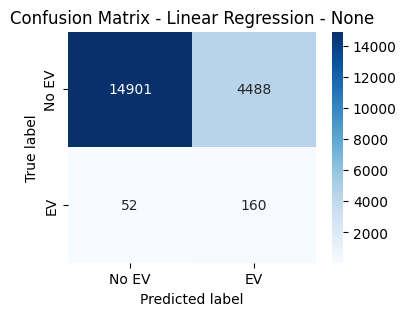

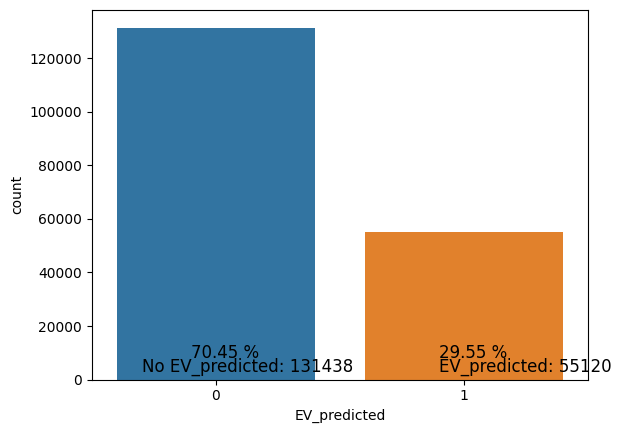

In [91]:
for i in range(1, 100):
    LR4 = perform_logistic_reg(cleaned_data, class_col='EV', sampling=None, weight={0: 1, 1: 99})
#     predict_and_visualize(LR4, 'EV', dataset=df)

In [48]:
# # anayzing with scaled data and perform LR
def scale_data_standard_scaler(data, feature_cols):
    scaled_data = data.copy()
    features = scaled_data[feature_cols]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    scaled_data[feature_cols] = features
    return scaled_data

# scaled_data = scale_data_standard_scaler(cleaned_data, billing_months)
# LR4 = perform_logistic_reg(scaled_data, class_col='EV' )
# predict_and_visualize(LR4,'EV', dataset=df)

In [18]:
# Perform RFE and find important features 

# @ignore_warnings(category=ConvergenceWarning)
# def perform_RFE(dataset, class_col='EV'):
#     test_df_1 = dataset.copy()

#     x = test_df_1.drop(class_col, axis=1)  
#     y = test_df_1[class_col]

#     model = LogisticRegression()
#     rfe_stand = RFE(model, n_features_to_select = 9 )
#     fit_stand = rfe_stand.fit(x, y)
#     print("St Model Num Features:", fit_stand.n_features_)
#     #print("St Model Selected Features:", fit_stand.support_)
#     print("Std Model Feature Ranking:", fit_stand.ranking_)
#     # calculate the score for the selected features
#     score_stand = rfe_stand.score(x,y)
# #     print("Standardized Model Score with selected features is: %f (%f)" % (score_stand.mean(), score_stand.std()))
#     feature_names = np.array(x.columns)
#     print('Most important features (RFE): %s'% feature_names[rfe_stand.support_])
    
#     return feature_names[rfe_stand.support_]

In [19]:
## Analysing important features with RFE

# RFE_data = cleaned_data.copy()
# # RFE_data = scale_data_standard_scaler(RFE_data, billing_months)

# imp_cols = perform_RFE(RFE_data)

# imp_data = RFE_data[imp_cols]
# imp_data['EV'] = cleaned_data['EV'].to_numpy()
# imp_LR = perform_logistic_reg(imp_data, class_col='EV')
# predict_and_visualize(imp_LR, 'EV', dataset = df[[imp_cols]])

Training set: Counter({0: 77553, 1: 847})
Testing set: Counter({0: 19389, 1: 212})
Training set: Counter({0: 847, 1: 847})
Testing set: Counter({0: 19389, 1: 212})
Tuned Decision Tree Parameters: {'min_samples_leaf': 2, 'max_features': 9, 'max_depth': 7, 'criterion': 'gini'}
Accuracy: 0.7781745829294424

              precision    recall  f1-score   support

           0       1.00      0.78      0.87     19389
           1       0.05      1.00      0.09       212

    accuracy                           0.78     19601
   macro avg       0.52      0.89      0.48     19601
weighted avg       0.99      0.78      0.87     19601


Average 5-Fold CV Score: 1.0 , Standard deviation: 0.0
Accuracy: 0.7781745829294424
Sensitivity :  0.7757491361081025
Specificity :  1.0


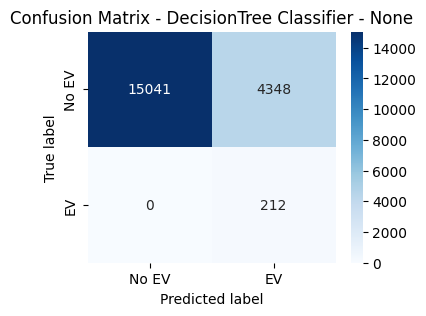

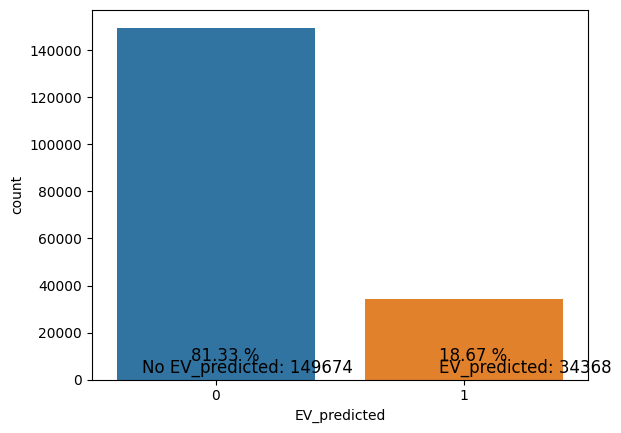

In [39]:
## Analysing with Decision tree algorithm

DT_data = cleaned_data.copy()

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [1,2,3,4,5,6,7,8,9],
              "max_features": [1,2,3,4,5,6,7,8,9],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_distributions=param_dist, cv=5, random_state=0)

x = DT_data.drop('EV', axis=1)  
y = DT_data['EV']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, stratify=y, random_state=42)
    
X_train, y_train = perform_sampling(X_train, y_train, y_test, sampling='under')

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 8, 
                                     max_features= 4, min_samples_leaf= 6, 
                                     random_state=0)
Tree.fit(X_train, y_train)
y_pred = Tree.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

get_metrics(y_pred, X_test, y_test, Tree, x, y, modal_name='DecisionTree Classifier')
predict_and_visualize(Tree ,  'EV', dataset=df[df.EV == 0])

Training set: Counter({0: 77553, 1: 847})
Testing set: Counter({0: 19389, 1: 212})
Training set: Counter({0: 847, 1: 847})
Testing set: Counter({0: 19389, 1: 212})
Tuned Random Forest Parameters: {'n_estimators': 200, 'max_features': 6, 'max_depth': 5, 'criterion': 'entropy'}
Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19389
           1       1.00      1.00      1.00       212

    accuracy                           1.00     19601
   macro avg       1.00      1.00      1.00     19601
weighted avg       1.00      1.00      1.00     19601


Average 5-Fold CV Score: 1.0 , Standard deviation: 0.0
Accuracy: 1.0
Sensitivity :  1.0
Specificity :  1.0


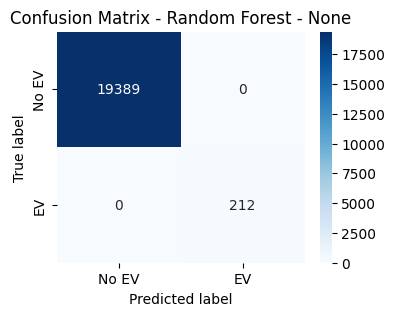

In [44]:
# # ## Random forest classification

RF_data = cleaned_data.copy()

param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6,7,8,9],
               'max_depth': [1,2,3,4,5,6,7,8,9],
               "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()

x = RF_data.drop('EV', axis=1)  
y = RF_data['EV']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, stratify=y, random_state=42)

X_train, y_train = perform_sampling(X_train, y_train, y_test, sampling='under')

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(x, y)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))


Ran = RandomForestClassifier(criterion= 'entropy', max_depth= 5, 
                                     max_features= 6, n_estimators= 200, 
                                     random_state=0)
Ran.fit(X_train, y_train)
y_pred = Ran.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

get_metrics(y_pred, X_test, y_test, Ran, x, y, modal_name="Random Forest")


In [22]:
# SVM_data = cleaned_data.copy()

# x = SVM_data.drop('EV', axis=1)  
# y = SVM_data['EV']

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# X_train, y_train = perform_sampling(X_train, y_train, y_test, 'under')

# SVM_Model = SVC(kernel='linear', C=1.0, class_weight='balanced')

# SVM_Model.fit(X_train,y_train)

# y_pred = SVM_Model.predict(X_test)
# print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

# get_metrics(y_pred, X_test, y_test, SVM_Model, x, y, modal_name="SVM")

# print (f'Accuracy - : {SVM_Model.score(x,y):.3f}')


Training set: Counter({0: 77553, 1: 847})
Testing set: Counter({0: 19389, 1: 212})
Training set: Counter({0: 847, 1: 847})
Testing set: Counter({0: 19389, 1: 212})
Accuracy of K-NN classifier on training set: 0.96
Accuracy of K-NN classifier on test set: 0.54
Accuracy: 0.5440028569970919

              precision    recall  f1-score   support

           0       1.00      0.54      0.70     19389
           1       0.02      0.90      0.04       212

    accuracy                           0.54     19601
   macro avg       0.51      0.72      0.37     19601
weighted avg       0.99      0.54      0.69     19601


Average 5-Fold CV Score: 1.0 , Standard deviation: 0.0
Accuracy: 0.5440028569970919
Sensitivity :  1.0
Specificity :  1.0


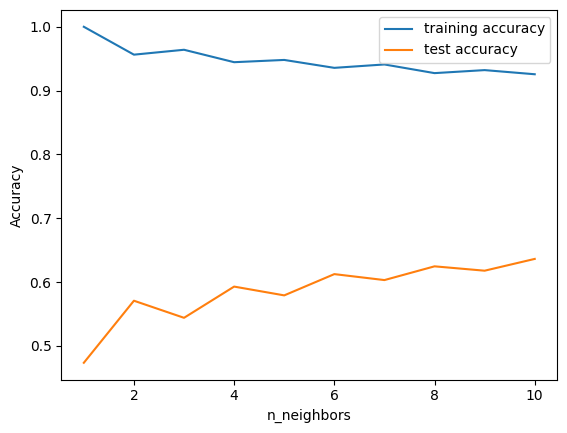

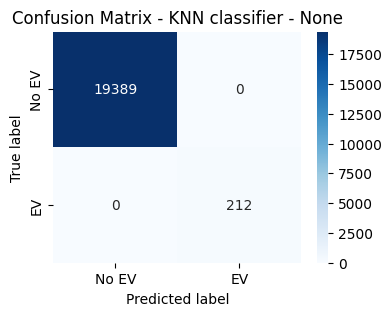

In [68]:
## KNN classification

KNN_data = cleaned_data.copy()

# KNN_data = scale_data_standard_scaler(KNN_data, KNN_data.columns)

# for month in KNN_data.columns:
#     KNN_data[month] = boxcox(KNN_data[month])[0]
    
x = KNN_data.drop('EV', axis=1)  
y = KNN_data['EV']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, stratify=y, random_state=42)

X_train, y_train = perform_sampling(X_train, y_train, y_test, sampling='under')

from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig('knn_compare_model')

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))


y_pred = knn.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

get_metrics(y_pred, X_test, y_test, Ran, x, y, modal_name="KNN classifier")



Training set: Counter({0: 77553, 1: 847})
Testing set: Counter({0: 19389, 1: 212})
Training set: Counter({0: 77553, 1: 77553})
Testing set: Counter({0: 19389, 1: 212})
Accuracy on training set: 1.000
Accuracy on test set: 1.000
Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19389
           1       1.00      1.00      1.00       212

    accuracy                           1.00     19601
   macro avg       1.00      1.00      1.00     19601
weighted avg       1.00      1.00      1.00     19601


Average 5-Fold CV Score: 1.0 , Standard deviation: 0.0
Accuracy: 1.0
Sensitivity :  1.0
Specificity :  1.0


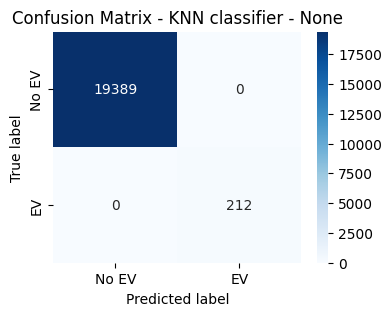

In [77]:

GraBo = cleaned_data.copy()

# KNN_data = scale_data_standard_scaler(KNN_data, KNN_data.columns)

# for month in KNN_data.columns:
#     KNN_data[month] = boxcox(KNN_data[month])[0]
    
x = GraBo.drop('EV', axis=1)  
y = GraBo['EV']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, stratify=y, random_state=42)

X_train, y_train = perform_sampling(X_train, y_train, y_test, sampling='over')

from sklearn.ensemble import GradientBoostingClassifier
gb = XGBClassifier(scale_pos_weight=99)
gb.fit(X_train, y_train)
print('Accuracy on training set: {:.3f}'.format(gb.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(gb.score(X_test, y_test)))
      
y_pred = gb.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

get_metrics(y_pred, X_test, y_test, Ran, x, y, modal_name="KNN classifier")


In [ ]:
model_results = pd.DataFrame(columns=[])

In [23]:
from IPython.display import HTML

HTML('''<script>
show=true; 
function code_toggle() {
 if (show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 show = !show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code blocks."></form>''')